In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import time

from tqdm.notebook import tqdm as tq
import itertools
import pandas as pd

pd.set_option('display.max_rows', None)

In [2]:
class Crescents(Dataset):
    
    def __init__(self, N, sep, thk, rad, device=torch.device('cpu')):
        '''
        parameters: 
        ---
        N : scalar (1,)
            numper of points to generate for each class
        sep : scalar (1,)
            seperation of the two hemisphseres (classes)
        thk : scalar (1,)
            thickness of the two hemisphseres (classes)
        rad : scalar (1,)
            Inner radius of the two hemisphseres (classes)

        '''
        self.device = device
        
        r = np.random.uniform(low=rad, high=(thk+rad), size=(N))
        phi = np.random.uniform(low=0, high=2*np.pi, size=(N))

        x_1 = np.multiply(r,np.cos(phi))
        x_2 = np.multiply(r,np.sin(phi))

        self.y_np = np.zeros(shape=(N,1))
        plus1s = np.squeeze(np.where(phi > np.pi))
        self.y_np[plus1s] = 1

        x_1[plus1s] = x_1[plus1s] + sep/2 + rad
        x_2[plus1s] = x_2[plus1s] - sep
        self.x_np = np.stack([x_1,x_2],axis=1)
        
        self.x = torch.from_numpy(self.x_np.astype(dtype=np.float32)).to(device)
        self.y = torch.from_numpy(self.y_np.astype(dtype=np.float32)).to(device)    
    
    
    def __len__(self):
        '''
        return number of patches
        '''
        return self.x.shape[0]

    
    def __getitem__(self, idx):
        '''
        return patch at idx
        '''
        sample = {'input':self.x[idx,:],'target':self.y[idx]}
        return sample


def plot_points(dataset,):
    fig,ax = plt.subplots()
    
    ax.plot(dataset.x_np[np.where(dataset.y_np==1),0],
               dataset.x_np[np.where(dataset.y_np==1),1],
               'ob'
    )
    ax.plot(dataset.x_np[np.where(dataset.y_np==0),0],
               dataset.x_np[np.where(dataset.y_np==0),1],
              'xr'
    )

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')
    plt.show()

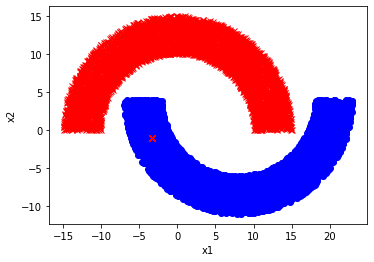

10000

In [3]:
DEVICE = torch.device('cpu')

N = 10000
rad=10
sep=-4
thk=5
dataset = Crescents(N,sep,thk,rad,DEVICE)
plot_points(dataset)

len(dataset)

In [4]:
class LagrangeMultiplierMLP(torch.nn.Module):
    def __init__(self,m,l,c,device=torch.device('cpu')):
        super(LagrangeMultiplierMLP, self).__init__()
        '''
        Parameters:
        ---
        m : scalar (1,)
            dimensionality of input
        l : scalar (1,)
            dimensionality of hidden layer
        c : scalar (1,)
            constraint value to be enforced by Lagrange multipliers, 
        if None, no constraint
        device : torch.device
        '''
        self.m = m
        self.l = l
        self.c = c 
        
        # weights of multipliers initialized to 1s
        self.lmbdas = torch.zeros((self.l,), device=device)
        
        # weights of linear layer initialized to U(-m^(-1/2),m^(-1/2))
        self.fc1 = torch.nn.Linear(self.m, self.l, device=device)
        self.relu = torch.nn.ReLU()
#         self.relu = torch.nn.LeakyReLU(negative_slope=0.1)
        self.fc2 = torch.nn.Linear(self.l, 1, device=device)
        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        '''
        Parameters:
        ---
        x : scalar (n_points,n_features)
        
        Returns:
        ---
        latent : scalar (n_points,latent_dim)
            latent dimension
        yhat : scalar (n_points,1)
            classification probability
        '''
        latent = self.relu(self.fc1(x))
        yhat = self.sigmoid(self.fc2(latent))
        return latent, yhat
        

    def lagrange_loss(self, y, yhat, latent):
        recon_loss = self.loss(y,yhat)
        lagrange_const = torch.sum(self.lmbdas*(torch.mean(latent-self.c,axis=0).square())) # \sum_i\lambda_i*(<latent_i-c>)
        return recon_loss + lagrange_const

    
    def loss(self,y,yhat,latent=None):
        return torch.nn.functional.mse_loss(y, yhat)
    
    
    def accuracy(self,y,yhat):
        return torch.mean((torch.round(yhat)==y).float())


    def checknan(self,data,name='data'):
        if torch.isnan(data).any():
            raise ValueError('LagrangeMultiplierMLP error: nan in %s.'%(name))

In [5]:
def train(model, loss_functional, dataset, optimizer, lmbda_lr, constraint, batch_size):
    model.train()
    train_loss = 0
    train_accuracy = 0
    
    ## ======================== 
    ## update weights
    ## ======================== 
    
    # define data loader
    dataloader = DataLoader(dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True
    )

    for batch_idx, batch in enumerate(dataloader):
        
        # zero out gradients
        optimizer.zero_grad()
        
        # compute forward pass
        latent, yhat = model(batch['input'])

        # calculate loss
        loss = loss_functional(yhat=yhat, y=batch['target'], latent=latent)
        accuracy = model.accuracy(yhat=yhat, y=batch['target'])
        
        # compute gradients
        loss.backward()

        # take a step
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += accuracy.item()
    
    train_accuracy /= len(dataloader)
    train_loss /= len(dataloader)
    
    ## ======================== 
    ## update multipliers
    ## ======================== 
    with torch.no_grad():
        constraint_violation = get_latent_activations(model,dataset,batch_size=batch_size) - constraint
        model.lmbdas = model.lmbdas + lmbda_lr*constraint_violation.mean(axis=0).square()

    return train_loss, train_accuracy


def get_latent_activations(model,dataset,batch_size=100):
    '''
    
    Parameters:
    ---
    model : torch.nn.Module
        autoencoder model
    dataset : torch.utils.data.Dataset
        dataset to compute latent activations for
    batch_size : scalar(1,)
    
    Returns:
    ---
    latent_activations : scalar (n_data_points,latent_dim)
        
    '''
    # define data loader
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=True
    )
    
    # compute latent activations
    latent_activations = torch.zeros([0,model.l])
    for batch_idx, batch in enumerate(dataloader):
        # compute forward pass
        latent, yhat = model(batch['input'])
        latent_activations = torch.vstack([latent_activations,latent])
    return latent_activations

In [8]:
LMBDA_LR = 1e-3
PARAM_LR = 1e-3
BATCH_SIZE = 500
HIDDEN_LAYER = 10
INPUT_LAYER = 2
CONSTRAINT = 2
N_EPOCH = 200

# define model
model = LagrangeMultiplierMLP(m=INPUT_LAYER,
                              l=HIDDEN_LAYER,
                              c=CONSTRAINT,
                              device=DEVICE)


optimizer = torch.optim.Adam([
    {'params': model.parameters(), 'lr': PARAM_LR}
])

losses = []
accuracies = []
lmbdas = np.zeros((0,HIDDEN_LAYER))
latent_activation_list = []

for i in tq(range(N_EPOCH)):
    l,a = train(model,
                model.lagrange_loss,
                dataset,
                optimizer=optimizer,
                batch_size=BATCH_SIZE,
                lmbda_lr=LMBDA_LR,
                constraint=CONSTRAINT
    )
    losses.append(l)
    accuracies.append(a)
    lmbdas = np.vstack([lmbdas, model.lmbdas.detach().cpu().numpy()])
    
    latent_activations = get_latent_activations(model,dataset).detach().cpu().numpy()
    latent_activation_list.append(latent_activations)
latent_activation_list = np.asarray(latent_activation_list)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 0, 'epoch')

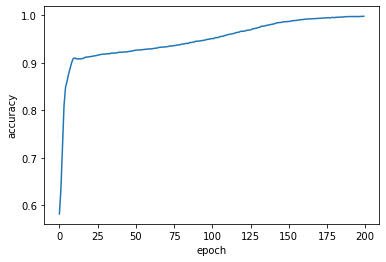

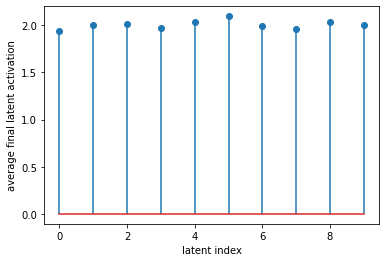

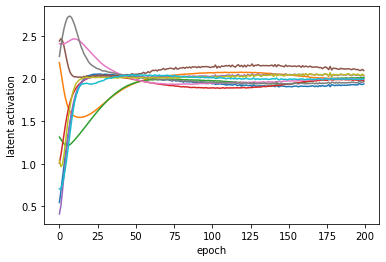

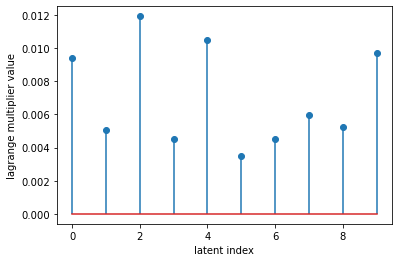

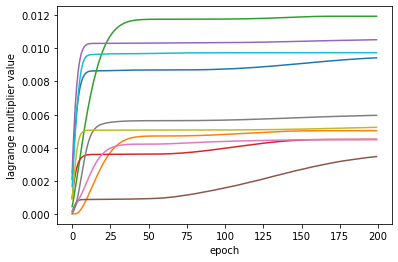

In [9]:
## PLOT RESULTS
fig,ax = plt.subplots()
ax.plot(accuracies)
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')

fig,ax = plt.subplots()
ax.stem(latent_activations.mean(axis=0))
ax.set_ylabel('average final latent activation')
ax.set_xlabel('latent index')

fig,ax = plt.subplots()
ax.plot(latent_activation_list.mean(axis=1))
ax.set_ylabel('latent activation')
ax.set_xlabel('epoch')

fig,ax = plt.subplots()
ax.stem(model.lmbdas.detach().cpu().numpy())
ax.set_ylabel('lagrange multiplier value')
ax.set_xlabel('latent index')

fig,ax = plt.subplots()
ax.plot(lmbdas)
ax.set_ylabel('lagrange multiplier value')
ax.set_xlabel('epoch')

---

# 
# Run tests

In [124]:
# define tests
INPUT_LAYER = 2
CONSTRAINT = 10
N_EPOCH = 100
    
batch_size_list = [100,500] #[50,75,100,250,500]
lmbda_lr_list = [1e-5,1e-3,1e-1]
w_lr_list = [1e-5,1e-3,1e-1]
hidden_layer_list = [2,5,10]
constraint_list = [1,5,10]

# package
hyperparams = [
    batch_size_list,
    lmbda_lr_list,
    w_lr_list,
    hidden_layer_list,
    constraint_list
]

results = []
result_dictionaries = []

cases = list(itertools.product(*hyperparams))
for case in tq(cases):
    
    batch_size, lmbda_lr, w_lr, hl_dim, c = case
    
    # define model
    model = LagrangeMultiplierMLP(m=INPUT_LAYER,
                                  l=hl_dim,
                                  c=c,
                                  device=DEVICE)

    # define data loader
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=True
    )

    lagrange_optimizer = torch.optim.Adam([
        {'params': model.lmbdas, 'lr': lmbda_lr},
        {'params': model.parameters(), 'lr': w_lr}
    ])

    losses = []
    accuracies = []
    lmbdas = np.zeros((0,hl_dim))
#     latent_activation_list = []
    
    # train model
    for i in range(N_EPOCH):
        l,a = train(model,model.lagrange_loss,dataloader,optimizer=lagrange_optimizer,epoch=i,disp=False)
        losses.append(l)
        accuracies.append(a)
        lmbdas = np.vstack([lmbdas, model.lmbdas.detach().cpu().numpy()])
        
    latent_activations = get_latent_activations(model,dataset)
        

    # store model infromation
    output_dict = {'loss':losses,'accuracy':accuracies,'lmbdas':lmbdas,'model':model,'latents':latent_activations}
    result_dictionaries.append(output_dict) 

    # store high level results
    results.append([batch_size, lmbda_lr, w_lr, hl_dim, c, accuracies[-1], latent_activations.mean()])

  0%|          | 0/162 [00:00<?, ?it/s]

In [132]:
columns = ['batch_size', 'lmbda_lr', 'w_lr', 'hidden_layers', 'constraint','final_accuracy','latent_activation']
data = {c: d for c, d in (zip(columns, list(zip(*results))))}
df = pd.DataFrame(data)
df[np.abs(df['constraint']-df['latent_activation']) < 0.5]

,batch_size,lmbda_lr,w_lr,hidden_layers,constraint,final_accuracy,latent_activation
27,100,0.00100,0.00001,2,1,65.75,1.235131
54,100,0.10000,0.00001,2,1,50.70,1.437035
57,100,0.10000,0.00001,5,1,67.55,1.234706
94,500,0.00001,0.00100,5,5,441.75,5.132453
97,500,0.00001,0.00100,10,5,453.75,5.419497
124,500,0.00100,0.00100,10,5,450.75,4.542471


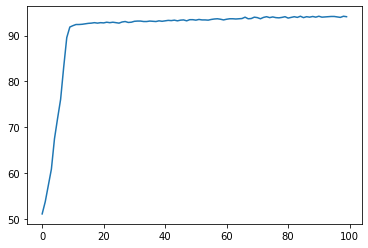

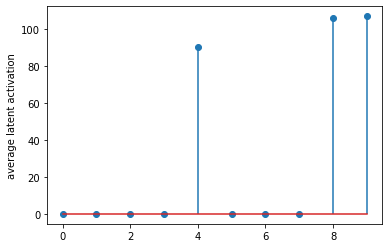

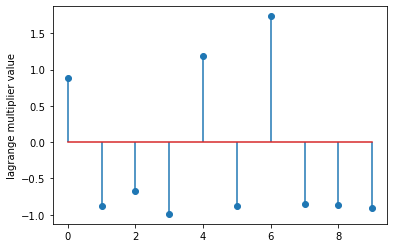

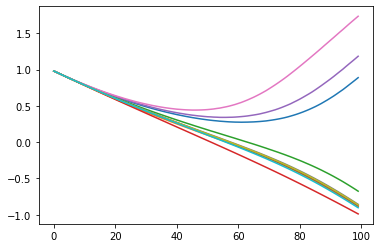

In [102]:
## PLOT RESULTS

fig,ax = plt.subplots()
ax.plot(accuracies)


fig,ax = plt.subplots()
ax.stem(latent_activations.mean(axis=0))
ax.set_ylabel('average latent activation')

fig,ax = plt.subplots()
ax.stem(model.lmbdas.detach().cpu().numpy())
ax.set_ylabel('lagrange multiplier value')

fig,ax = plt.subplots()
ax.plot(lmbdas)

In [98]:
def train(model, loss_functional, train_loader, optimizer, lagrange_optimizer, epoch=0, log_interval=500,disp=True):
    model.train()
    train_loss = 0
    train_accuracy = 0

    for batch_idx, batch in enumerate(train_loader):
        
        # zero out gradients
        optimizer.zero_grad()
        
        # compute forward pass
        latent, yhat = model(batch['input'])
        
        # calculate loss
        loss = loss_functional(yhat=yhat, y=batch['target'], latent=latent)
        accuracy = model.accuracy(yhat=yhat, y=batch['target'])
        
        # compute gradients
        loss.backward()

        # take a step
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += accuracy.item()
        
        
        # print some stuff
        if disp:
            if batch_idx % log_interval == 0:
                print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                    time.ctime(time.time()), 
                    epoch, 
                    batch_idx*len(batch),
                    len(train_loader.dataset), 
                    100.*batch_idx/len(train_loader), 
                    loss.item(),
                    accuracy.item()),
                )
    
    lagrange_optimizer.zero_grad()
    # update lagrange multipliers
    for batch_idx, batch in enumerate(train_loader):
        
        # compute forward pass
        latent, yhat = model(batch['input'])
        
        # calculate loss
        loss = loss_functional(yhat=yhat, y=batch['target'], latent=latent)
        
        # compute gradients
        loss.backward()    
    lagrange_optimizer.step()
    
    train_accuracy /= len(train_loader)
    train_loss /= len(train_loader)
    if disp:
        print('Train set Average loss: ', train_loss)
        print('Train set Average accuracy:', train_accuracy)
    return train_loss, train_accuracy


(100, 10)